## Import Dependencies

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
import sqlite3 #for querying data 
import datetime

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Data Analysis: Statistics and Machine Learning Libraries
from scipy import stats
import scikit_posthocs as sp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Import Dataset
 - Data downloaded from https://data.lacity.org/resource/63jg-8b9z.json on 12/3/19

In [2]:
# import data using read_csv() method
df = pd.read_csv("/Users/trinitycisneros/Documents/Coding/bitterscientist.com/Crime_Data_from_2010_to_Present.csv")

## Filter Dataset

In [3]:
# This study will evaluate trends in weapon related crimes, and as such, will use the following features
weapon_crime_df = df[['Date Rptd', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Crm Cd 1', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'AREA NAME' , 'LAT', 'LON']]
# Renamed columns
weapon_crime_df.columns = ["Date_Reported", "Vict_Age", "Vict_Sex", "Vict_Desc", "Crime_Code", "Weapon_Code", "Weapon_Desc", "Status", "Area_Name", "Lat", "Lng"]

## Omit all records missing data

In [4]:
weapon_crime_df = weapon_crime_df.dropna(how='any', subset=['Weapon_Desc', 'Vict_Sex', 'Vict_Desc', 'Crime_Code', 'Status']).copy()

## Update Column Datatypes

In [6]:
# Create lists for categorical and int columns
cat_col = ['Vict_Sex', 'Vict_Desc', 'Weapon_Desc', 'Status', 'Area_Name']
int_col = ['Vict_Age', 'Weapon_Code', 'Crime_Code']

In [7]:
# Convert events column into int using a for loop
for col in int_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('int64')

In [8]:
# Convert events column into category using a for loop
for col in cat_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('category')

## Relabel categorical data

In [9]:
descent_dict = {'A' : 'Other Asian', 'B' : 'Black', 'C' : 'Chinese', 'D' : 'Cambodian', 'F' : 'Filipino', 'G' : 'Guamanian', 'H' : 'Hispanic/Latin/Mexican', 'I' : 'American Indian/Alaskan Native', 'J' : 'Japanese', 'K' : 'Korean', 'L' : 'Laotian', 'O' : 'Other', 'P' : 'Pacific Islander', 'S': 'Samoan', 'U': 'Hawaiian', 'V': 'Vietnamese', 'W': 'White', 'X': 'Unknown', 'Z':'Asian Indian'}

In [10]:
weapon_crime_df['Vict_Desc'].replace(descent_dict, inplace= True)

### Research Questions
### What are the top 10 crimes involving weapons
### What are the top 10 weapons reported in crimes
### What are general features of the all victims
### How have weapon related crimes changed over the reporting period
 - What are the victim profiles
 - What was the crime reported
### In the past year, where were these crimes committed?
### In the past year, are there regional differences in weapon usage accross the city?
### How does a regions annual household income affect weapon related crimes?

## What are the top 10 crimes involving weapons

In [11]:
# Get the top 10 crimes
wc_top_10 = weapon_crime_df['Crime_Code'].value_counts()[0:9]

In [12]:
# To rename the crime codes with their crime description prepare a list of crimes
index_ = ['Battery - misdemeanor', 'Spousal/Cohab Abuse - Simple Assault', 'Assault with a Deadly Weapon', 'Robbery', 'Criminal Threats', 'Spousal beating', 'Brandishing', 'Robbery - attempted', 'Assault on Firefighter or Peace Officer With Deadly Weapon']

In [13]:
# Set the index 
wc_top_10.index = index_

In [14]:
# Prepare a dataframe
wc_top_10_df = pd.DataFrame(wc_top_10)

In [15]:
# Rename column
wc_top_10_df.columns=["Total Count"]
wc_top_10_df

,Total Count
Battery - misdemeanor,188920
Spousal/Cohab Abuse - Simple Assault,107657
Assault with a Deadly Weapon,91803
Robbery,83030
Criminal Threats,48813
Spousal beating,15151
Brandishing,14637
Robbery - attempted,11880
Assault on Firefighter or Peace Officer With Deadly Weapon,10934


## What are the top 10 weapons reported in crimes

In [17]:
# Get the top 10 crimes
weapon_top_10 = weapon_crime_df['Weapon_Desc'].value_counts()[0:9]

In [18]:
weapon_top_10_df = pd.DataFrame(weapon_top_10)
weapon_top_10_df.columns=["Total Count"]
weapon_top_10_df

,Total Count
"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",426874
VERBAL THREAT,58216
UNKNOWN WEAPON/OTHER WEAPON,56890
HAND GUN,33834
SEMI-AUTOMATIC PISTOL,12815
KNIFE WITH BLADE 6INCHES OR LESS,12746
OTHER KNIFE,9706
UNKNOWN FIREARM,7850
VEHICLE,7176


## What are general features of the all victims
 - Age
 - Sex
 - Age by Sex

In [19]:
# Descriptive statistics for victim age for all sexes
weapon_crime_df[['Vict_Age']].describe()

,Vict_Age
count,704416.000000
mean,33.096876
std,16.755117
min,-9.000000
25%,22.000000
50%,31.000000
75%,45.000000
max,99.000000


In [20]:
# Find out what is the age descriptive statistics by sex
vict_age_by_sex = weapon_crime_df.groupby('Vict_Sex')['Vict_Age'].describe()
# Drop non M or F categories
vic_age_by_sex = vict_age_by_sex.drop(['H', 'N', 'X'])
vic_age_by_sex

,count,mean,std,min,25%,50%,75%,max
Vict_Sex,,,,,,,,
F,360786.0,33.071001,15.220637,-8.0,22.0,30.0,43.0,99.0
M,333823.0,34.004113,17.674571,-8.0,22.0,33.0,47.0,99.0


## Visualize distribution of data for victim age

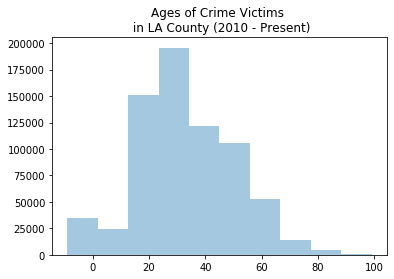

In [21]:
# Plot all the victim age for all victims
sns.distplot(weapon_crime_df[['Vict_Age']], bins=10, kde=False).set_title('Ages of Crime Victims \n in LA County (2010 - Present)')
plt.savefig("static/images/vict_age_all_histogram.png", bbox_inches='tight')
plt.show()

In [22]:
# Subset data by victim sex for only known sexes
all_F_age_data = weapon_crime_df.loc[weapon_crime_df["Vict_Sex"] == "F"][['Vict_Age']]
all_M_age_data = weapon_crime_df.loc[weapon_crime_df["Vict_Sex"] == "M"][['Vict_Age']]

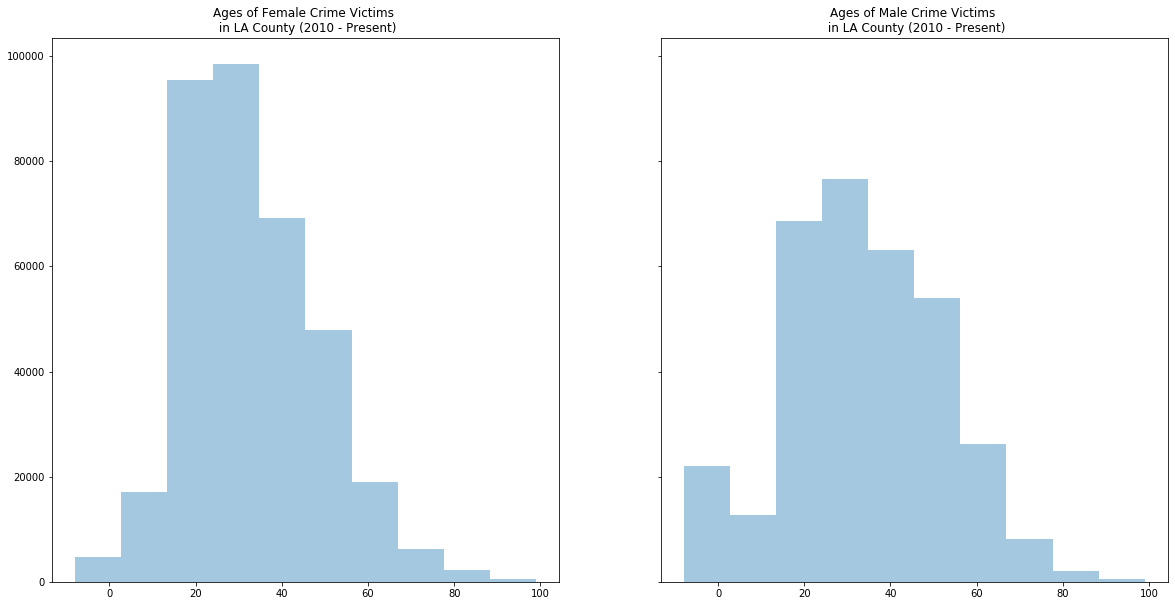

In [23]:
# Plot all the victim age for all victims
fig1, axs1 = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 10))
sns.distplot(all_F_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[0]).set_title('Ages of Female Crime Victims \n in LA County (2010 - Present)')
sns.distplot(all_M_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[1]).set_title('Ages of Male Crime Victims \n in LA County (2010 - Present)')
fig1.savefig("static/images/vict_age_by_sex_histograms.png", bbox_inches='tight')
plt.show()

In [25]:
weapon_crime_df.columns

Index(['Date_Reported', 'Vict_Age', 'Vict_Sex', 'Vict_Desc', 'Crime_Code',
       'Weapon_Code', 'Weapon_Desc', 'Status', 'Area_Name', 'Lat', 'Lng'],
      dtype='object')

In [31]:
top10_vict_desc = weapon_crime_df['Vict_Desc'].value_counts()[0:10]
top10_vict_desc_df = pd.DataFrame(top10_vict_desc)
top10_vict_desc_df.columns=["Total Count"]
top10_vict_desc_df

,Total Count
Hispanic/Latin/Mexican,333313
Black,168582
White,123302
Other,47720
Unknown,14416
Other Asian,12706
Korean,3074
Filipino,633
American Indian/Alaskan Native,220
Chinese,145


In [ ]:
# Dataset: All batted events for Bregman, Rendon, and Soto
# Selected only the to 10 batting events
order = top10_vict_desc

sns.set(rc={'figure.figsize':(25,15)})
sns.set(font_scale=1.5)
result_events = sns.countplot(x='Vict_Desc', hue = "batter", data=weapon_crime_df, order=order)
result_events.set_xticklabels(result_events.get_xticklabels(), rotation=45)
fig = result_events.get_figure()
fig.savefig("static/images/bar_plot_vict_desc.png", bbox_inches='tight') 

In [ ]:
# Dataset: All batted events for Bregman, Rendon, and Soto
# Selected only the to 10 batting events
order = batted_events_df.events.value_counts().index[:10]

sns.set(rc={'figure.figsize':(25,15)})
sns.set(font_scale=1.5)
result_events = sns.countplot(x='events', hue = "batter", data=batted_events_df, order=order)
result_events.set_xticklabels(result_events.get_xticklabels(), rotation=45)
fig = result_events.get_figure()
fig.savefig("static/images/batter_event_bar_plots.png", bbox_inches='tight') 

In [ ]:
order = weapon_crime_df['Vict_Desc'].value_counts()[:10]
order

In [ ]:
sns.countplot(x="Vict_Desc", data=weapon_crime_df)
plt.show()

## How have weapon related crimes changed over the reporting period
 - What are the victim profiles
 - What was the crime reported

## In the past year, where were these crimes committed?

## In the past year, are there regional differences in weapon usage accross the city?

## How does a regions annual household income affect weapon related crimes?